# Brain Tumor Classification and Level Segmentation


<img src="https://www.10faq.com/assets/img/causes-of-trigeminal-neuralgia-03.jpg" alt="Brain" style="width: 800px; height:100px">

---

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
data_dir = '/content/drive/MyDrive/btmri'

# List contents of the directory
os.listdir(data_dir)

# Define paths to training and testing data
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# List contents of the training directory
os.listdir(train_dir)

# List contents of the testing directory
os.listdir(test_dir)

# Now you can access data from 'train_dir' and 'test_dir' to load your dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['pituitary', 'meningioma', 'glioma', 'notumor']

---

# Color

defining colors for useabaility. when we have to use colors we can just access it through array indexing concept

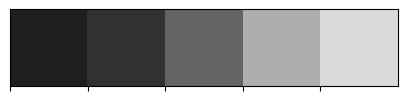

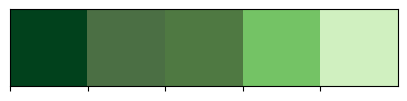

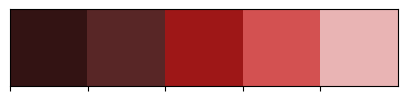

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preprosessing
we have labeled dataset for **glioma, meningioma, pituitary & no_tumor **.


In [ ]:
labels = ['glioma','no_tumor','meningioma','pituitary']


 It initializes lists for storing the images and their corresponding labels, defines the image size, and then loads and resizes the images from specified directories.

In [ ]:
labels = ['glioma','notumor','meningioma','pituitary']
X_train = []
y_train = []
image_size = 150

# Load training data
for label in labels:
    folder_path = os.path.join(train_dir, label)
    for image_name in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, image_name))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(label)

# Load testing data
for label in labels:
    folder_path = os.path.join(test_dir, label)
    for image_name in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, image_name))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 330/330 [00:05<00:00, 57.55it/s] 


# Sampling


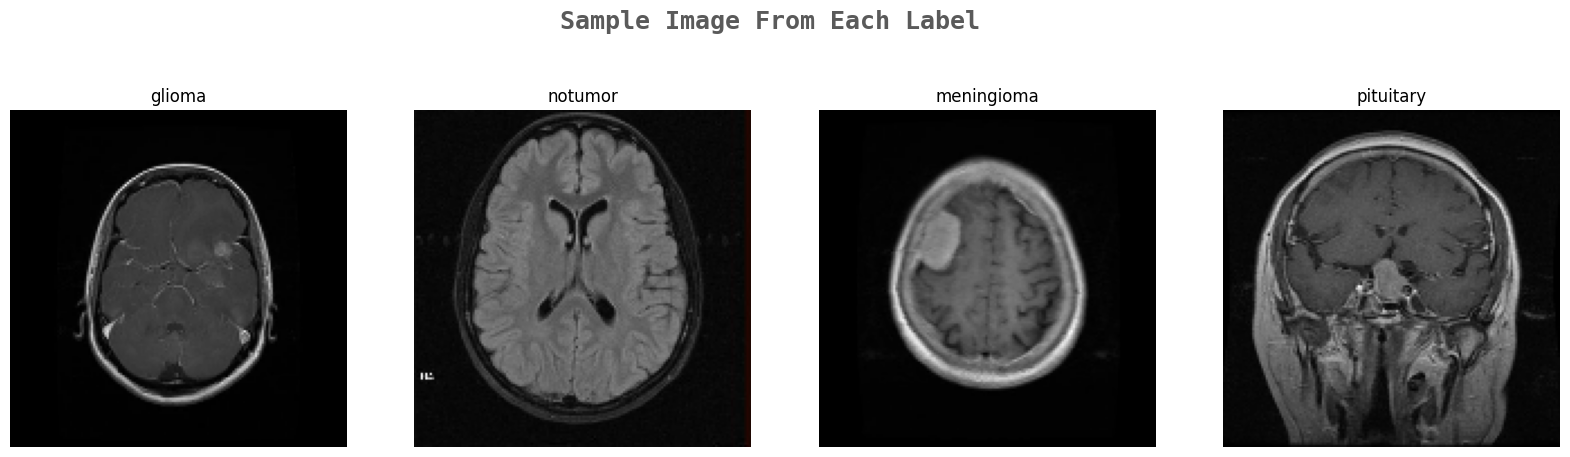

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(7063, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

 # **One Hot Encoding**

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Machine Learning Model



In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.



<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*93Ahac6GAA04fnpVPcKZBg.png" />

<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*cwMpOJNhwOeosjwW-usYvA.png" />



<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*rnhgFRXetwD8PvxhZIpwIA.png" />

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
print(f"Total number of layers in EfficientNetB0: {len(effnet.layers)}")

Total number of layers in EfficientNetB0: 238


In [ ]:
for layer in effnet.layers[:230]:
    layer.trainable = False

# Build the model
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1[0][0]'

We finally compile our model.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

training the neural network model, saves the trained model, and stores the training history for later use.


In [ ]:


from tensorflow.keras.models import load_model
import pickle

# Train your model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=32,
                    callbacks=[tensorboard, checkpoint, reduce_lr])

# Save the trained model
model.save('/content/drive/MyDrive/btmri/model.h5')

# Save the training history
with open('/content/drive/MyDrive/btmri/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)




Epoch 1/12
179/179 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8545
Epoch 1: val_accuracy improved from -inf to 0.92296, saving model to effnet.h5
179/179 [==============================] - 16s 47ms/step - loss: 0.3763 - accuracy: 0.8545 - val_loss: 0.2222 - val_accuracy: 0.9230 - lr: 0.0010
Epoch 2/12
179/179 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9267
Epoch 2: val_accuracy improved from 0.92296 to 0.92767, saving model to effnet.h5
179/179 [==============================] - 7s 39ms/step - loss: 0.1889 - accuracy: 0.9267 - val_loss: 0.1821 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 3/12
179/179 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9510
Epoch 3: val_accuracy improved from 0.92767 to 0.93868, saving model to effnet.h5
179/179 [==============================] - 7s 37ms/step - loss: 0.1318 - accuracy: 0.9510 - val_loss: 0.1551 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 4/12
178/179 [=============

# Save model for future use

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Load the saved model
model = load_model('/content/drive/MyDrive/btmri/model.h5')

# Load the training history
with open('/content/drive/MyDrive/btmri/history.pkl', 'rb') as file:
    history = pickle.load(file)

# Now you can access the training history as `history`


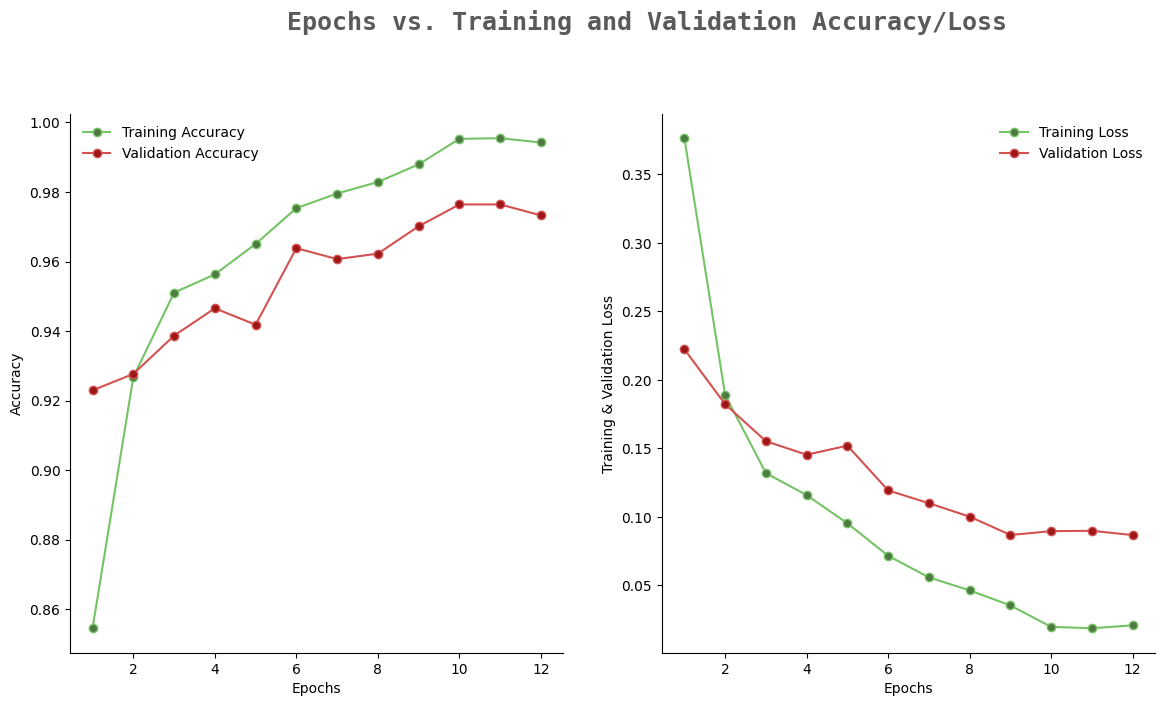

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load the training history
with open('/content/drive/MyDrive/btmri/history.pkl', 'rb') as file:
    history = pickle.load(file)

epochs = range(1, len(history['accuracy']) + 1)
fig, ax = plt.subplots(1,2,figsize=(14,7))

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, history['accuracy'], marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Accuracy')
ax[0].plot(epochs, history['val_accuracy'], marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, history['loss'], marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs, history['val_loss'], marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()


---

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

23/23 [==============================] - 3s 31ms/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       161
           1       1.00      1.00      1.00       202
           2       0.97      0.98      0.97       177
           3       0.98      0.98      0.98       167

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707



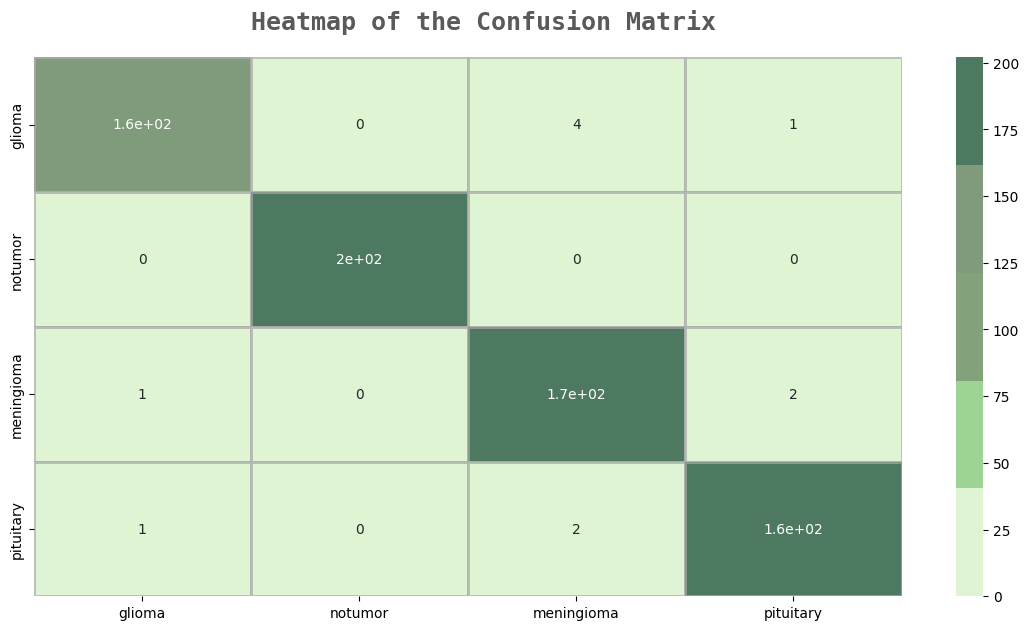

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

#Prediction

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is and Level / Grade of the tumor through **segmentation** of the tumor.<br>


In [ ]:

# Define a function to preprocess the image and segment the tumor region
def preprocess_image(image):
    # Apply image processing techniques to segment tumor region
    # For demonstration purposes, let's assume simple thresholding to detect the tumor region
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    _, segmented_tumor_region = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    return segmented_tumor_region

# Define a function to extract features from the segmented tumor region
def extract_features(segmented_tumor_region):
    # For demonstration purposes, let's extract the area of the tumor region as a feature
    area = np.sum(segmented_tumor_region / 255)
    return area

# Define a function to predict tumor grade based on extracted features
def predict_grade(features):
    # For demonstration purposes, let's divide the grades into four categories
    if features <= 3000:
        return 'Grade 1'
    elif (features > 3000 and features  <= 6000) :
        return 'Grade 2'
    elif  (features > 6000 and features  <= 9000):
        return 'Grade 3'
    else:
        return 'Grade 4'

# Define a function to perform prediction on uploaded image
def img_pred(upload):
    for name, file_info in upload.value.items():
        img = Image.open(io.BytesIO(file_info['content']))

    # Preprocess the image to segment tumor region
    segmented_tumor_region = preprocess_image(img)

    # Extract features from segmented tumor region
    features = extract_features(segmented_tumor_region)

    # Predict tumor grade based on extracted features
    predicted_grade = predict_grade(features)

    # Perform tumor type prediction using the model
    img = cv2.resize(np.array(img), (150, 150))
    img = img.reshape(1, 150, 150, 3)
    prediction = model.predict(img)
    predicted_type_index = np.argmax(prediction)
    tumor_types = ['Glioma Tumor', 'No Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
    predicted_type = tumor_types[predicted_type_index]

    if predicted_type in ['Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']:
        print(f"The model predicts {predicted_type} with {predicted_grade} for the uploaded image.")
    else:
        print("No tumor detected.")

# Code for uploading image and initiating prediction
uploader = widgets.FileUpload()
button = widgets.Button(description='Predict')
out = widgets.Output()

def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')

button.on_click(on_button_clicked)
display(uploader)
display(button)
display(out)


FileUpload(value={}, description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()

---

---

# <center>Thank You!